In [259]:
from keras.datasets import mnist
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats 

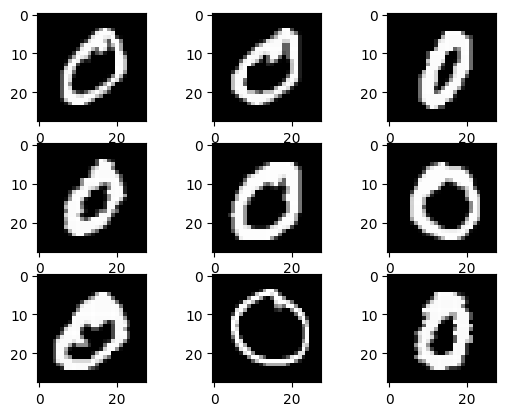

In [260]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_mask = np.isin(y_train, [0]) #0 here says only choose 0
x_train0 = x_train[train_mask]
y_train = y_train[train_mask]

x_train0 = x_train0 / 255.0 #normalize so grayscale is from 0 - 1

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train0[i], cmap=plt.get_cmap('gray'))

In [261]:
#convert to 1d array, choose some length for the num of images

def to_1Darr(x_train, length):
    
    zeros = x_train[0:length]
    arrays1D = np.zeros((length,784))

    for i, zero in enumerate(zeros):
        num = 0
        for j in range(28):
            for k in range(28):
                arrays1D[i][num] = zero[j][k]
                num = num + 1

    return arrays1D


In [262]:
# reading data for transition probabilities

file_path = "transition_0_1_neg.txt"
with open(file_path, 'r') as f:
    lines = f.readlines()

data = [list(map(float, line.strip().split())) for line in lines if line.strip()]
split_index = len(data) // 2
voltage_rows = data[:split_index]
prob_rows = data[split_index:]

volts_01_og = np.array([val for row in voltage_rows for val in row])
probs_01_og= np.array([val for row in prob_rows for val in row])

file_path = "transition_1_0_pos.txt"

with open(file_path, 'r') as f:
    lines = f.readlines()

data = [list(map(float, line.strip().split())) for line in lines if line.strip()]
split_index = len(data) // 2
voltage_rows = data[:split_index]
prob_rows = data[split_index:]

volts_10_og = np.array([val for row in voltage_rows for val in row])
probs_10_og = np.array([val for row in prob_rows for val in row])

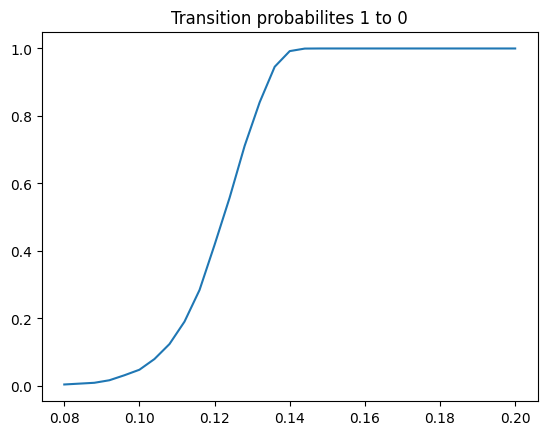

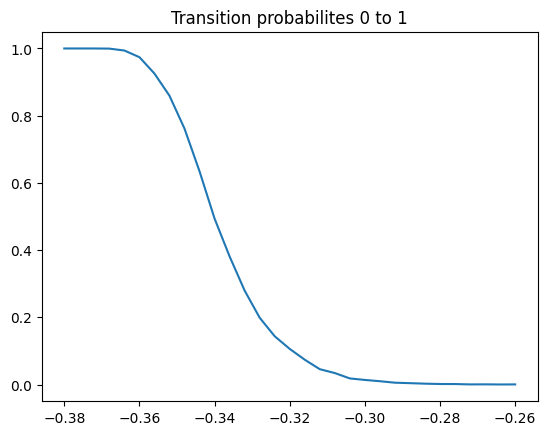

In [266]:
plt.plot(volts_10_og, probs_10_og)
plt.title("Transition probabilites 1 to 0")
plt.show()

plt.plot(volts_01_og, probs_01_og)
plt.title("Transition probabilites 0 to 1")
plt.show()


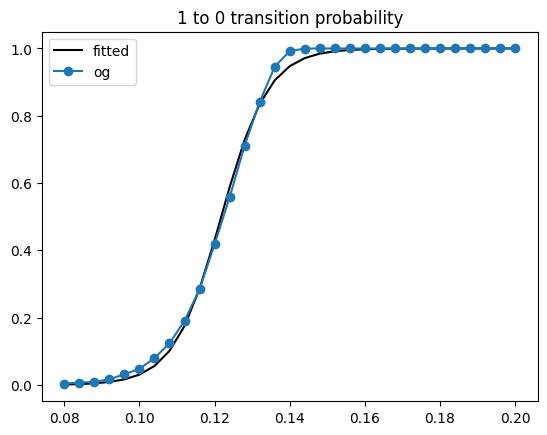

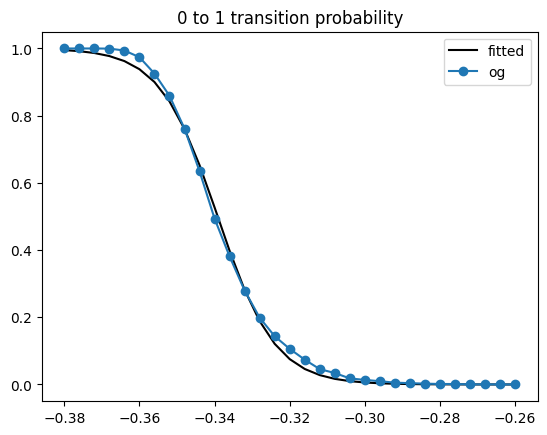

In [270]:
#sig modeling functions

def sig_fit(x, x0, k):
    return 1 / (1+np.exp(-k*(x-x0)))

x0_guess = np.median(volts_10_og)
k_guess = 10 

p0 = [x0_guess, k_guess]
volts_fit10, ___ = curve_fit(sig_fit, volts_10_og, probs_10_og, p0=p0)
x0, k = volts_fit10 #correct  x0, k values

plt.plot(volts_10_og, sig_fit(volts_10_og, x0, k), 'k', label = 'fitted')
plt.plot(volts_10_og, probs_10_og, 'o-', label = 'og')
plt.title("1 to 0 transition probability")
plt.legend()
plt.show()

x0_guess = np.median(volts_01_og)
p0 = [x0_guess, k_guess]
volts_fit01, ___ = curve_fit(sig_fit, volts_01_og, probs_01_og, p0=p0)
x0, k = volts_fit01

plt.plot(volts_01_og, sig_fit(volts_01_og, x0, k), 'k', label = 'fitted')
plt.plot(volts_01_og, probs_01_og, 'o-', label = 'og')
plt.title("0 to 1 transition probability")
plt.legend()
plt.show()


In [268]:
def find_matching_volt(gray_num, grayscale, volts_range):
    percentile = scipy.stats.percentileofscore(grayscale, gray_num)
    return np.percentile(volts_range, percentile)
        

def create_pulsetrain(grayscale, volts_range):
    pulse_train = np.zeros(len(grayscale))
    
    for i, gray_num in enumerate(grayscale):

        # if gray_num > 0.5:
        #     pulse_train[i] = find_matching_volt(gray_num, grayscale, volts_range)

        # else:
        #     pulse_train[i] = find_matching_volt(gray_num, grayscale, volts_range)

        pulse_train[i] = find_matching_volt(gray_num, grayscale, volts_range)
        

    return pulse_train
        
        

#matrix and calculation functions

def trans_matrix(pulse, sigfit, fitted_pars10, fitted_pars01):
    matrix = np.zeros((2,2))
    
    x0, k = fitted_pars10
    prob10 = sigfit(pulse, x0, k)

    x0, k = fitted_pars01
    prob01 = sigfit(pulse, x0, k)


    matrix[0][0] =  1 - prob01
    matrix[0][1] = prob01
    matrix[1][0] = prob10
    matrix[1][1] = 1 - prob10

    #print(f"This is the transition matrix: for pulse {pulse}: {matrix}")

    return matrix
    
    

def find_final_matrix(pulses, sigfit, fitted_pars10, fitted_pars01):
    matrices = np.zeros((len(pulses), 2, 2,))
    final_matrix = np.identity(2)
    
    for i, pulse in enumerate(pulses):
        matrices[i] = trans_matrix(pulse, sigfit, fitted_pars10, fitted_pars01)

        if i != 0:
            final_matrix = np.dot(final_matrix, matrices[i-1])         
    return final_matrix

def find_steady_state(matrix):
    assert matrix.shape == (2, 2)
    eigenvals, eigenvecs = np.linalg.eig(matrix.T)

    index = np.argmin(np.abs(eigenvals - 1))

    vec1 = eigenvecs[:, index]
    return vec1/np.sum(vec1)

In [242]:
volt_range_change

array([-0.308, -0.304, -0.3  , -0.296, -0.292, -0.288, -0.284, -0.28 ,
       -0.276, -0.272, -0.268, -0.264, -0.26 ,  0.08 ,  0.084,  0.088,
        0.092,  0.096,  0.1  ,  0.104,  0.108,  0.112,  0.116])

In [279]:
x0_guess = np.median(volts_10_og)
k_guess = 10 

p0 = [x0_guess, k_guess]
volts_fit10, ___ = curve_fit(sig_fit, volts_10_og, probs_10_og, p0=p0)
x0, k = volts_fit10 #correct  x0, k values

sig_fit(0.12177239927609437, x0, k)

0.5

In [278]:
x0

0.12177239927609437

In [285]:
x0_01

NameError: name 'x0_01' is not defined

In [287]:
#make zeros into 1D array
zeros = to_1Darr(x_train0, 15) #randomly choosing 15 images here

x0_guess = np.median(volts_10_og)
k_guess = 10 

p0 = [x0_guess, k_guess]

volts_fit10, ___ = curve_fit(sig_fit, volts_10_og, probs_10_og, p0=p0)
x0_10, __ = volts_fit10 #correct  x0, k values
#find the pulse with probability of 0.5 which is the same thing as x0 

x0_guess = np.median(volts_01_og)
p0 = [x0_guess, k_guess]

volts_fit01, ___ = curve_fit(sig_fit, volts_01_og, probs_01_og, p0=p0)
x0_01 , _ = volts_fit01

volts_10 = volts_10_og[ volts_10_og < x0]
volts_01 = volts_01_og[volts_01_og > x0_01]
volt_range_change  = np.concatenate([volts_01, volts_10])


for zero in zeros:
    pulsetrain = create_pulsetrain(zero, volt_range_change)
    final_matrix = find_final_matrix(pulsetrain, sig_fit, volts_fit10, volts_fit01)
    steady_state = find_steady_state(final_matrix)
    print("this is steady state", steady_state)
    

this is steady state [0.81888166 0.18111834]
this is steady state [0.76806486 0.23193514]
this is steady state [0.82043127 0.17956873]
this is steady state [0.7674236 0.2325764]
this is steady state [0.77003738 0.22996262]
this is steady state [0.7959668 0.2040332]
this is steady state [0.74071548 0.25928452]
this is steady state [0.87715246 0.12284754]
this is steady state [0.79477105 0.20522895]
this is steady state [0.82991413 0.17008587]
this is steady state [0.81332621 0.18667379]
this is steady state [0.78810118 0.21189882]
this is steady state [0.7914782 0.2085218]
this is steady state [0.80028848 0.19971152]
this is steady state [0.71260853 0.28739147]


this is steady state [0.92695725 0.07304275]
this is steady state [0.91804655 0.08195345]
this is steady state [0.94403295 0.05596705]
this is steady state [0.93928328 0.06071672]
this is steady state [0.92277096 0.07722904]
this is steady state [0.83687179 0.16312821]
this is steady state [0.93583549 0.06416451]
this is steady state [0.91438523 0.08561477]
this is steady state [0.91786997 0.08213003]
this is steady state [0.87377801 0.12622199]
this is steady state [0.93463305 0.06536695]
this is steady state [0.93235765 0.06764235]
this is steady state [0.8990163 0.1009837]
this is steady state [0.93258282 0.06741718]
this is steady state [0.93665887 0.06334113]
this is steady state [0.93253106 0.06746894]
this is steady state [0.90337969 0.09662031]
this is steady state [0.92502344 0.07497656]
this is steady state [0.89616163 0.10383837]
this is steady state [0.94629932 0.05370068]


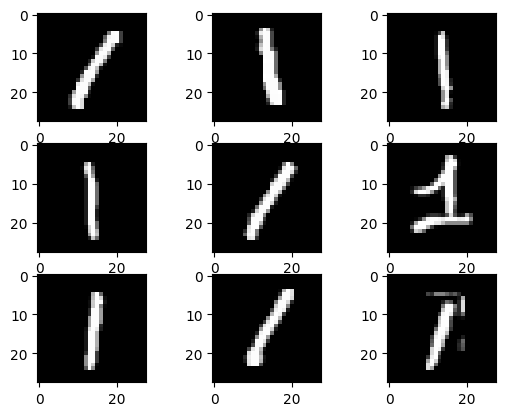

In [288]:
#find steady state vectors for 1s 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_mask = np.isin(y_train,[1] )
x_train1 = x_train[train_mask]
y_train = y_train[train_mask]

x_train1 = x_train1 / 255.0

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train1[i], cmap=plt.get_cmap('gray'))


ones = to_1Darr(x_train1, 20) #randomly choosing 15 images here

# volts_10 = volts_10_og[ volts_10_og < 0.14]
# volts_01 = volts_01_og[volts_01_og > -0.34]
# volt_range_change  = np.concatenate([volts_01, volts_10])



for one in ones:
    pulsetrain = create_pulsetrain(one, volt_range_change)
    final_matrix = find_final_matrix(pulsetrain, sig_fit, volts_fit10, volts_fit01)
    steady_state = find_steady_state(final_matrix)
    print("this is steady state", steady_state)

this is steady state [0.94310072 0.05689928]
this is steady state [0.92045315 0.07954685]
this is steady state [0.96828161 0.03171839]
this is steady state [0.97381496 0.02618504]
this is steady state [0.98320865 0.01679135]
this is steady state [0.88442355 0.11557645]
this is steady state [0.9694238 0.0305762]
this is steady state [0.91677045 0.08322955]
this is steady state [0.98178685 0.01821315]
this is steady state [0.95114428 0.04885572]
this is steady state [0.93773409 0.06226591]
this is steady state [0.94876733 0.05123267]
this is steady state [0.91974268 0.08025732]
this is steady state [0.89731549 0.10268451]
this is steady state [0.98006268 0.01993732]
this is steady state [0.97879438 0.02120562]
this is steady state [0.92726489 0.07273511]
this is steady state [0.94542563 0.05457437]
this is steady state [0.95583884 0.04416116]
this is steady state [0.98620806 0.01379194]


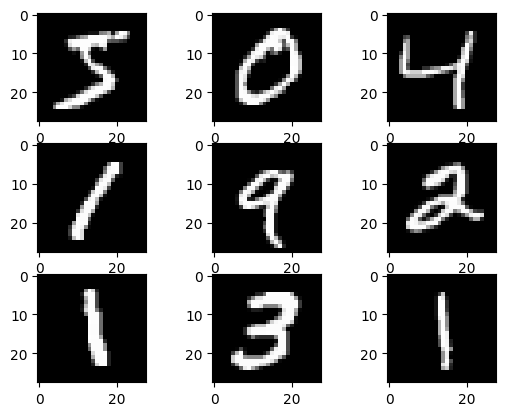

In [253]:
#find steady state vectors for any number

(x_train_any, y_train), (x_test, y_test) = mnist.load_data()

x_train_any = x_train_any / 255.0

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_any[i], cmap=plt.get_cmap('gray'))


random_nums = to_1Darr(x_train_any, 20) #randomly choosing 15 images here
volts_10 = volts_10_og[ volts_10_og < 0.14]
volts_01 = volts_01_og[volts_01_og > -0.34]
volt_range_change  = np.concatenate([volts_01, volts_10])

for num_image in random_nums:
    pulsetrain = create_pulsetrain(num_image, volt_range_change)
    final_matrix = find_final_matrix(pulsetrain, sig_fit, volts_fit10, volts_fit01)
    steady_state = find_steady_state(final_matrix)
    print("this is steady state", steady_state)